# Machine Learning Engineer Nanodegree
## Deep Learning
## Capstone project: Rock-paper-scissors Classifier
### by Juan Andrés Ramírez

In this notebook is described the work done for the Udacity's Machine Learning Nanodegree capstone project

First make most of the imports:

In [42]:
from sklearn.datasets import load_files       

import numpy as np
from glob import glob
import os
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib.pyplot as plt
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense #Conv2D, MaxPooling2D,
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential

from tqdm import tqdm

#### Exploring dataset
First we will start exploring the dataset and making some preprocessing. Below we load the dataset

In [2]:

#Train folder
train_folder = 'datasets/train'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)

# load list of classes
#class_names = [item[20:-1] for item in sorted(glob(train_folder +"/*/"))]
class_names = [name for name in os.listdir(train_folder)]

# print statistics about the dataset
print('There are %d total class categories.' % len(class_names))
#print('There are %s total class images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
#print('There are %d validation images.' % len(valid_files))
#print('There are %d test images.'% len(test_files))
print('Classes: ')
for class_str in class_names:
    print(' - ' + class_str)

There are 3 total class categories.
There are 360 training images.
Classes: 
 - papel
 - piedra
 - tijera


Now we may see some of the training images:

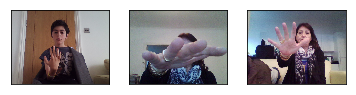

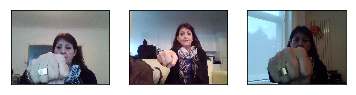

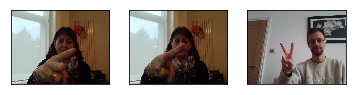

In [68]:

n_class_elements_to_show = 3

def load_image_for_show(image_path):
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

def plot_img_from_path(image_path, axes=None):
    img = load_image_for_show(image_path)
    if axes:
        axes.imshow(img)
        axes.set_xticks([])
        axes.set_yticks([])
    else:
        plt.imshow(img)

train_target_int = np.array([ np.where(r==1)[0][0] for r in train_targets ])

for class_label in range(len(class_names)):
    class_indexes = np.nonzero(train_target_int==class_label)    
    f, axarr = plt.subplots(1, 3)    
    for to_show in range(n_class_elements_to_show):
        img_index = class_indexes[0][to_show]
        img_path = train_files[img_index]        
        plot_img_from_path( img_path, axarr[to_show])
plt.show()

Dataset: images re-scaling and offline augmentation

In [13]:


augmentation_factor = 10
aug_dir = 'dataset_aug'

# Resize image
def resize_image(img_path):
    #Load image
    img = cv2.imread(img_path)
        
    #Preprocess
    img = cv2.resize(img, (224,224))

# Write augmented dataset to disk
def generate_augmented():
    
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir)
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    for j in range(len(train_files)):#range(1):
        img_path = train_files[j]
        img =  load_img(img_path) #resize_image(img_path)
        img = img.resize((224,224)) 
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 224, 224)
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        out_dir = aug_dir + "/" + class_names[ train_target_int[j] ]
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        i = 0
        for batch in datagen.flow(x, batch_size=1,seed = 9, save_to_dir=out_dir, save_prefix='aug-'+str(j).zfill(3), save_format='jpeg'):
            i += 1
            if i >= augmentation_factor:
                break  # otherwise the generator would loop indefinitely

#Uncomment the next line to generate the augmented database
generate_augmented() 
print('Ok!')
 

Ok!


Now we load the augmented database and get features using ResNet50

In [58]:
 #decode_predictions
aug_dir = 'dataset_aug_mini'
# load train, test, and validation datasets
train_files_aug, train_targets_aug = load_dataset(aug_dir)
print('There are %d total class categories.' % len(class_names))
print('There are %d training images.' % len(train_files_aug))

# Load ResNet50
def get_ResNet50():
    model_features_Resnet50 = ResNet50( include_top=False,
                                        weights='imagenet',
                                        input_tensor=None,
                                        input_shape=None,
                                        pooling=None)
    return model_features_Resnet50


#def path_to_tensor(img_path):
#    # loads RGB image as PIL.Image.Image type
#    img = image.load_img(img_path, target_size=(224, 224))
#    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#    x = image.img_to_array(img)
#    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#    return np.expand_dims(x, axis=0)

#def paths_to_tensor(img_paths):
#    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
#    return np.vstack(list_of_tensors)
   
def process_ResNet50(model_features_Resnet50, image_path):
    #Load image
    img = cv2.imread(image_path)
        
    #Preprocess      
    x = image.img_to_array(img)    
    img_tensor= np.expand_dims(x, axis=0)
    #Preprocess image for Resnet50
    img_preproccessed = preprocess_input(img_tensor)     
    
    #Obtain Resnet50 features    
    img_features = model_features_Resnet50.predict(img_preproccessed)
   
    return img_features

def get_features_from_db(path_list):
    model_features_Resnet50 = get_ResNet50()
    n_paths = len(path_list)
    features = []
    i = 0
    for image_path in path_list:
        features.append(process_ResNet50(model_features_Resnet50, image_path))
        if n_paths>100:
            if (i % (n_paths//10)) == 0:
                print ("Completed", i/n_paths*100, "[%]")
        i += 1
    features_array = np.concatenate(features, axis=0)
    return features_array

features_array = get_features_from_db(train_files_aug)
#print(features)

There are 3 total class categories.
There are 150 training images.
[array([[[[ 0.69168007,  0.78018725,  0.31145754, ...,  0.6249814 ,
           0.19722256,  0.00365762]]]], dtype=float32), array([[[[ 0.21880712,  0.33241466,  0.02966661, ...,  0.01662735,
           0.74868196,  0.26394606]]]], dtype=float32), array([[[[ 2.19138169,  0.61021978,  0.00843093, ...,  0.87543607,
           0.10160997,  0.38192531]]]], dtype=float32), array([[[[ 0.31361639,  0.55539143,  0.31156063, ...,  2.02213001,
           0.36206993,  0.1450623 ]]]], dtype=float32), array([[[[ 0.36547154,  0.75999802,  0.28743237, ...,  0.24909361,
           0.77090311,  1.0337255 ]]]], dtype=float32), array([[[[ 0.36382335,  0.06292615,  0.24631368, ...,  2.29445815,
           1.65732765,  0.69567126]]]], dtype=float32), array([[[[ 0.97647536,  0.57514614,  0.0663332 , ...,  1.1752336 ,
           0.09160911,  0.21997833]]]], dtype=float32), array([[[[ 0.59875137,  0.29042363,  0.        , ...,  0.49072897,
    

Here we define the model

In [48]:
#Defining architecture.

model_1 = Sequential()
print(features_array.shape[1:])
model_1.add(GlobalAveragePooling2D(input_shape=features_array.shape[1:]))
model_1.add(Dense(3, activation='softmax'))

model_1.summary()

(1, 1, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 6,147.0
Trainable params: 6,147.0
Non-trainable params: 0.0
_________________________________________________________________


In [49]:
model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Training the model

In [51]:
#Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model_1.hdf5', 
                               verbose=1, save_best_only=True)

model_1.fit(features_array, train_targets_aug, 
          validation_split=0.2,
          #validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 120 samples, validate on 30 samples
Epoch 1/20
120/120 [==============================] - 0s - loss: 0.0278 - acc: 1.0000 - val_loss: 0.1046 - val_acc: 0.9667
Epoch 2/20
120/120 [==============================] - 0s - loss: 0.0528 - acc: 0.9833 - val_loss: 0.1249 - val_acc: 0.9667
Epoch 3/20
120/120 [==============================] - 0s - loss: 0.0265 - acc: 1.0000 - val_loss: 0.1376 - val_acc: 0.9333
Epoch 4/20
120/120 [==============================] - 0s - loss: 0.0247 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.9667
Epoch 5/20
120/120 [==============================] - 0s - loss: 0.0225 - acc: 1.0000 - val_loss: 0.1330 - val_acc: 0.9333
Epoch 6/20
120/120 [==============================] - 0s - loss: 0.0178 - acc: 1.0000 - val_loss: 0.0746 -

Now, we check classification over some training samples

Image: dataset_aug_mini\tijera\aug-013_0_6782.jpeg , prediction: tijera


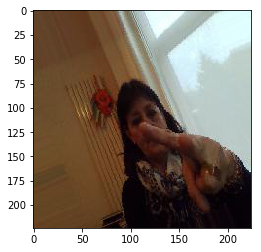

Image: dataset_aug_mini\piedra\aug-003_0_6715.jpeg , prediction: piedra


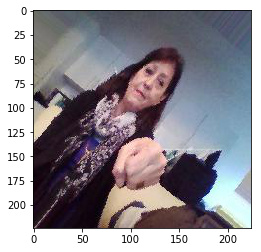

Image: dataset_aug_mini\papel\aug-005_0_6765.jpeg , prediction: papel


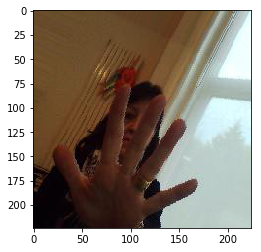

Image: dataset_aug_mini\tijera\aug-011_0_8413.jpeg , prediction: tijera


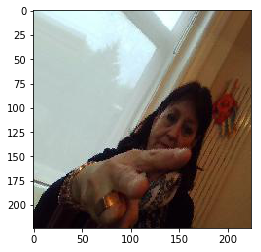

Image: dataset_aug_mini\papel\aug-000_0_8413.jpeg , prediction: papel


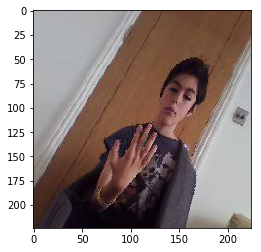

Image: dataset_aug_mini\tijera\aug-011_0_3725.jpeg , prediction: tijera


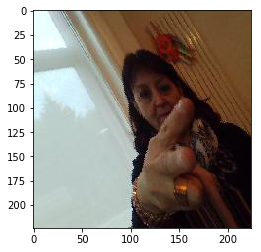

Image: dataset_aug_mini\papel\aug-007_0_3725.jpeg , prediction: papel


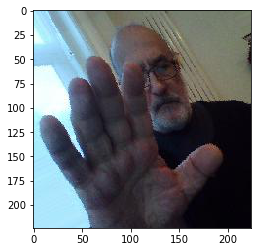

Image: dataset_aug_mini\piedra\aug-009_0_7656.jpeg , prediction: piedra


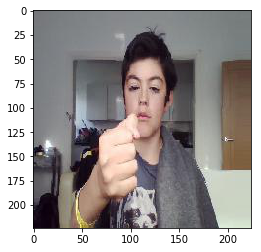

Image: dataset_aug_mini\piedra\aug-006_0_7656.jpeg , prediction: piedra


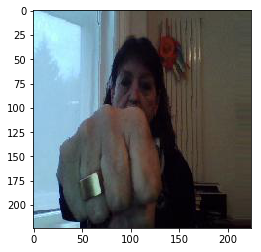

In [69]:
model_1.load_weights('saved_models/weights.best.model_1.hdf5')

def classify_images(img_paths):
    paths_features = get_features_from_db(img_paths)
    #Calc predictions
    rps_predictions = [np.argmax(model_1.predict(np.expand_dims(tensor, axis=0))) for tensor in paths_features]
    rps_predictions_string = [class_names[class_index] for class_index in rps_predictions]
    return rps_predictions, rps_predictions_string

def show_prediction (img_path, pred_str):
    print('Image:', img_path, ', prediction:', pred_str)
    plot_img_from_path(img_path)
    #img = cv2.imread(img_path)
    #plt.imshow(img)
    plt.show()
    
showing_paths = train_files_aug[0:9]
#print (showing_paths)
pred, pred_str = classify_images(showing_paths)
for i in range(len(showing_paths)):
    show_prediction (showing_paths[i], pred_str[i])
#print(pred_str)